In [1]:
!pip3 install torch
!pip3 install tqdm
!pip3 install nltk
!pip3 install pandas
!pip3 install numpy
!pip3 install seaborn
!apt-get install wget
!pip3 install youtokentome

     |████████████████████████████████| 734.6MB 28kB/s s eta 0:00:01  |▏                               | 4.6MB 7.3MB/s eta 0:01:41     |▍                               | 9.5MB 7.3MB/s eta 0:01:40     |█▉                              | 42.6MB 7.3MB/s eta 0:01:36     |███▊                            | 85.0MB 58.5MB/s eta 0:00:12     |████▍                           | 99.6MB 51.2MB/s eta 0:00:13     |████▊                           | 108.6MB 51.2MB/s eta 0:00:13     |████████▎                       | 189.2MB 46.2MB/s eta 0:00:12     |███████████                     | 251.7MB 35.3MB/s eta 0:00:14     |██████████████▋                 | 335.5MB 37.6MB/s eta 0:00:11     |███████████████                 | 343.4MB 37.6MB/s eta 0:00:11�██████████▉                | 363.0MB 38.9MB/s eta 0:00:10     |████████████████▎               | 374.1MB 38.9MB/s eta 0:00:10     |██████████████████▍             | 420.9MB 37.2MB/s eta 0:00:09     |████████████████████▋           | 473.0MB 62.1MB/s eta 0:00:05��█

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm.auto import tqdm

from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm.auto import tqdm

import pandas as pd

import numpy as np

from torch.utils.data import Dataset, DataLoader


In [3]:
import math
import random
import json
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

from matplotlib import pyplot as plt

import youtokentome as yttm

In [4]:
#ИЗМЕНИТЬ ПУТЬ В ЗАВИСИМОСТИ ОТ ТОГО ГДЕ ЗАПУСКАЕМ КОД
try:
    df = pd.read_csv("ctx_quest.csv")
except:
    df = pd.read_csv("/Users/lilyakhoang/input/question_generation/ctx_quest.csv")

df.head()

,Unnamed: 0,context,question
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?
1,1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...
2,2,"Managed by her father, Mathew Knowles, the gro...",When did Beyonce leave Destiny's Child and bec...
3,3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?
4,4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?


In [5]:
df_nonan = df.dropna()
df_nonan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86610 entries, 0 to 86820
Data columns (total 3 columns):
Unnamed: 0    86610 non-null int64
context       86610 non-null object
question      86610 non-null object
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


In [6]:
# обучаем
vocab_size = 16000
model_path = 'bpe.model'

# yttm.BPE.train(data='for_bpe_ctx_quest.txt', vocab_size=vocab_size, model=model_path)

In [7]:
tokenizer = yttm.BPE(model=model_path)

In [8]:
# давайте токенизируем наш датасет
# токенизирую батчами, потому что так быстрее
# также в начало добавляем токен bos (begin of sentence)

tokenized_ctx = []
tokenized_quest = []
batch_size = 256

for i_batch in tqdm(range(math.ceil(len(df_nonan.context) / batch_size))):
    
    tokenized_ctx.extend(tokenizer.encode(list(df_nonan.context[i_batch*batch_size:(i_batch+1)*batch_size])))

for i_batch in tqdm(range(math.ceil(len(df_nonan.question) / batch_size))):

    tokenized_quest.extend(tokenizer.encode(list(df_nonan.question[i_batch*batch_size:(i_batch+1)*batch_size])))

In [9]:
class WordData(torch.utils.data.Dataset):
    def __init__(self, context_list, questions_list, context_len, questions_len, pad_index, eos_index):
        self.context_list = context_list
        self.questions_list = questions_list
        
        self.context_len = context_len
        self.questions_len = questions_len
        
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.context_list)
    
    def __getitem__(self, index):
        
        encoder_sequence = self.context_list[index][:self.context_len]
        decoder_sequence = self.questions_list[index][:self.questions_len]
        
        target_sequence = decoder_sequence[:] + [self.eos_index]
        decoder_sequence = decoder_sequence[:]
        
        encoder_pads = [self.pad_index] * (self.context_len - len(encoder_sequence))
        decoder_pads = [self.pad_index] * (self.questions_len - len(decoder_sequence))
        target_pads = [self.pad_index] * (self.questions_len - len(decoder_sequence))
        
        encoder_sequence = torch.tensor(encoder_sequence + encoder_pads).long()
        decoder_sequence = torch.tensor(decoder_sequence + decoder_pads).long()
        target_sequence = torch.tensor(target_sequence + target_pads).long()
        
        return encoder_sequence, decoder_sequence, target_sequence

In [10]:
batch_size = 64

context_len = 80
quest_len = 20

pad_index = 0
eos_index = 3

In [11]:
validation_start_index = int(len(tokenized_ctx) * 0.1)

In [12]:
train_dataset = WordData(context_list=tokenized_ctx[:-validation_start_index],
                         questions_list = tokenized_quest[:-validation_start_index],
                         context_len=context_len, questions_len = quest_len, pad_index=pad_index, eos_index=eos_index)

validation_dataset = WordData(context_list=tokenized_ctx[-validation_start_index:],
                              questions_list = tokenized_quest[-validation_start_index:],
                         context_len=context_len, questions_len = quest_len, pad_index=pad_index, eos_index=eos_index)

len(train_dataset), len(validation_dataset)

(77949, 8661)

In [34]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64)

In [14]:
for encoder_sequence, decoder_sequence, target_sequence in train_loader:
    print(encoder_sequence[0], decoder_sequence[0], target_sequence[0])
    break

tensor([ 3297,  1394,  1304, 13539, 12243,  1838,  4502,  4113,  8059, 13895,
          100,    90,    65,   197,     9,  1444,   112,    76,  1348,     5,
           42,    73,    62,    51,  2250,  1398,    47,  4690,  2117,  2811,
         6982,  2156,  8762,  1352,  1306,  1959,  2339,  2087,  3046,  7582,
         2087,  2083,  7536,  1312,  1875, 11109,  1365,  2117,  1312,  5267,
         1305,  4274, 13461, 15846,  2402,  4829,  1305,  2734, 10861,  1312,
         1317,  9041, 12046,  1363,  1285, 12745,  1312,  7309,  1319, 13738,
         1305,  1287,  2535,  7915,  1363,  2018,  8292,  1300,  9914,  8155]) tensor([1800, 1503, 7635, 2294, 4596, 2454,   36,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]) tensor([1800, 1503, 7635, 2294, 4596, 2454,   36,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0])


In [18]:
class SimpleSequence2Sequence_attention_cycle(torch.nn.Module):
    def __init__(self, vocab_size=16000, embedding_size=256,
                 hidden_size=256, num_layers=2, dropout=0.3, padding_idx=0):
        
        super().__init__()
        self.hidden_size = hidden_size
        
        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_size, padding_idx)
        
        self.encoder = torch.nn.GRU(embedding_size, hidden_size, 
                                    num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.decoder = torch.nn.GRU(hidden_size, hidden_size, 
                                    num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.head = torch.nn.Linear(hidden_size*2, vocab_size)
        
    def forward(self, encoder_sequence, decoder_sequence, debug = True):
        encoder_embed = self.embedding_layer(encoder_sequence)
        encoder_hidden, encoder_mem = self.encoder(encoder_embed)
        decoder_mem = encoder_mem#.transpose(0,1).transpose(1,2)
        decoder_embed = self.embedding_layer(decoder_sequence)
        decoder_embed = torch.cat([encoder_hidden[:, -1, :].unsqueeze(1), decoder_embed], dim=1)
        word_predictions = torch.zeros(64,21,16000).to(device)
        for timestamp in range(decoder_embed.size(1)):
            current_step = decoder_embed[:, timestamp, :]
            current_decoder_rnn_hidden, decoder_mem = self.decoder(current_step.unsqueeze(1), decoder_mem)
            attention_scores = torch.bmm(current_decoder_rnn_hidden, encoder_hidden.transpose(1, 2))
            attention_distribution = torch.softmax(attention_scores, 2)
            current_decoder_attention = torch.bmm(attention_distribution, encoder_hidden)
            cat = torch.cat([current_decoder_attention, current_decoder_rnn_hidden], dim = -1)
            word_prediction = self.head(cat)
            word_predictions[:,timestamp,:] = word_prediction.squeeze(1)
        
        return word_predictions

In [32]:
def train(model, iterator, criterion, optimizer):
    
   # Put the model in training mode!
    model.train()

    losses_list = []
    epoch_loss = 0
    progress_bar = tqdm(iterator, total=len(iterator))
    
    for encoder_sequence, decoder_sequence, target_sequence in progress_bar:
        
        optimizer.zero_grad()
        encoder_sequence = encoder_sequence.to(device)
        decoder_sequence = decoder_sequence.to(device)
        target_sequence = target_sequence.to(device)

        output = model(encoder_sequence, decoder_sequence)
        output = output.view(-1, output.size(-1))
        
        target_sequence = target_sequence.view(-1)
        loss = criterion(output, target_sequence)
        losses_list.append(float(loss.item()))
        
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix(train_loss = np.mean(losses_list[-500:]))
    return losses_list

In [38]:
model = SimpleSequence2Sequence_attention_cycle()
model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [ ]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.show()

In [43]:
torch.save(SimpleSequence2Sequence_attention_cycle.state_dict, "s2s")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [44]:
torch.save(optimizer.state_dict, "Adam")

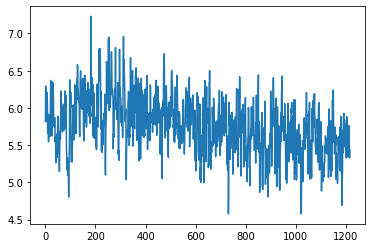

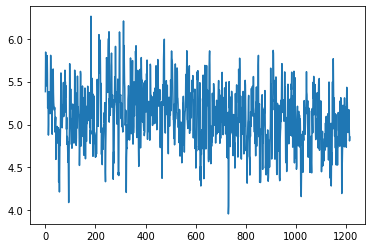

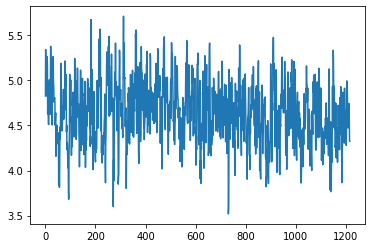

KeyboardInterrupt: 

In [42]:
all_losses = []
av_losses = []
for e in range(5):
    losses_list = train(model, train_loader, criterion, optimizer)
    av_losses.append(np.mean(losses_list))
    if np.mean(losses_list) > av_losses[-1] and len(av_losses) > 1:
        break
    all_losses.extend(losses_list)
    plt.plot(losses_list)
    plt.show()


In [41]:
np.mean([1,2,2])

1.6666666666666667

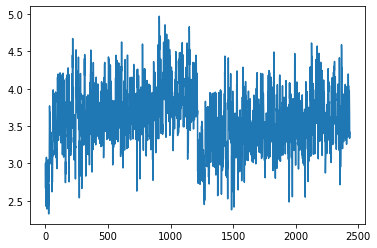

In [37]:
plt.plot(all_losses)
plt.show()